In [1]:
# Import `numpy` under the alias `np`
import numpy as np 

# Import `pandas` under the alias `pd`
import pandas as pd 
import pmdarima as pm

import itertools #to iterate through the loops

import statsmodels.api as sm

import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 

import plotly.express as px
import plotly.offline as py

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pandas import Series

from datetime import datetime
from matplotlib import pyplot


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#FBProphet related imports
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Importing the Auto-Arima function 
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

 # to split the data into train and test parts
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score 


def p_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Reading the data from a file

In [3]:
df = pd.read_excel('Sales_Forecast_Data-Original.xlsx')

In [4]:
df.head() # returns top n (5 by default) rows of a data frame

FIN_YEAR MONTH    STATE            FG DISTRICT  COMPANY    VALUE
0  2014-2015   Nov  Haryana  Insecticides   Rohtak  monous    675.00
1  2014-2015   Nov  Haryana  Insecticides   Rewari  monous     73.71
2  2014-2015   Nov  Haryana  Insecticides  Gurgaon  monous    405.00
3  2014-2015   Nov  Haryana  Insecticides    Mewat  monous   1188.00
4  2014-2015   Nov  Haryana  Insecticides   Palwal  monous   5188.59

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230152 entries, 0 to 230151
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FIN_YEAR  230152 non-null  object 
 1   MONTH     230152 non-null  object 
 2   STATE     230152 non-null  object 
 3   FG        230152 non-null  object 
 4   DISTRICT  230152 non-null  object 
 5   COMPANY   230152 non-null  object 
 6   VALUE     230152 non-null  float64
dtypes: float64(1), object(6)
memory usage: 12.3+ MB


# Data Preparation for modelling : using ABC Manufacturing data only

In [6]:
#Constants used within this file
train_start_date = '2014-01-01'
train_end_date = '2016-12-01'
test_start_date = '2017-01-01'
test_end_date = '2017-12-01'
consider_rolling_window = True
consider_mean_values = False
predict_periods=12
missing_record_index = 37

In [7]:
if consider_rolling_window == True:
    rolling_period = 3
else:
    #do not change this value
    rolling_period = 1     

In [8]:
#Creating a dataframe of ABC manufacturing
ABC_df = df.loc[df['COMPANY'] == 'ABC Manufacturing']

In [9]:
#converting year range to year  . for example  "2014-2015"  will be converted to 2014 
ABC_df['FIN_YEAR'] = ABC_df.FIN_YEAR.str.slice(0,4)

#converting month to datetime for checking stationarity  
ABC_df['MONTH'] = pd.to_datetime(ABC_df['FIN_YEAR'].astype(str)+ "-"+ ABC_df['MONTH'].astype(str) + "-1")

In [10]:
ABC_df.isnull().sum() #Checking the null values in the ABC manufacturing company

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [11]:
ABC_df.isna().sum() 

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [12]:
#Considering only Haryana data for ABC manufacturing company only
ABC_df = ABC_df.loc[ (ABC_df['STATE'] == 'Haryana')]
ABC_df

FIN_YEAR      MONTH    STATE            FG      DISTRICT  \
49         2014 2014-12-01  Haryana  Insecticides        Ambala   
50         2014 2014-12-01  Haryana  Insecticides   Yamunanagar   
51         2014 2014-12-01  Haryana  Insecticides        Karnal   
52         2014 2014-12-01  Haryana  Insecticides       Panipat   
53         2014 2014-12-01  Haryana  Insecticides       Sonipat   
...         ...        ...      ...           ...           ...   
229808     2016 2016-06-01  Haryana  Bactericides   Kurukshetra   
229809     2016 2016-06-01  Haryana  Bactericides  Mahendragarh   
229815     2016 2016-12-01  Haryana  Bactericides         Mewat   
229816     2016 2016-12-01  Haryana  Bactericides         Mewat   
230015     2016 2016-09-01  Haryana  Bactericides        Karnal   

                  COMPANY      VALUE  
49      ABC Manufacturing   6019.380  
50      ABC Manufacturing    425.250  
51      ABC Manufacturing  14782.635  
52      ABC Manufacturing   4031.910  
53      ABC Manufacturing   8692.110  
...                   ...        ...  
229808  ABC Manufacturing      0.000  
229809  ABC Manufacturing      0.000  
229815  ABC Manufacturing      0.000  
229816  ABC Manufacturing      0.000  
230015  ABC Manufacturing      0.000  

[6028 rows x 7 columns]

In [13]:
ABC_df.describe()

VALUE
count   6028.000000
mean     940.150862
std     2408.979798
min        0.000000
25%        0.000000
50%       22.882500
75%      515.193750
max    26035.560000

In [14]:
ABC_df_Pesticides = ABC_df.copy(deep=True)
ABC_df_Pesticides.drop(['FIN_YEAR', 'STATE', 'FG', 'DISTRICT', 'COMPANY'],axis=1,inplace = True)

In [15]:
# Upon inspection it is found that for a period of Feb and March in 2017, there was no data. 
# We need to treat this data else seasonal_decompose() will throw error

In [16]:
# SUM 

if consider_mean_values == False:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].sum().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':79640.325}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':110978.28 }
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])                                 

In [17]:
# MEAN 

if consider_mean_values == True:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].mean().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':811 }
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':1085 }
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])
    

In [18]:
ABC_df_Pesticides

MONTH       VALUE
0   2014-01-01 00:00:00  128078.820
1   2014-02-01 00:00:00  107427.060
2   2014-03-01 00:00:00  110342.925
3   2014-04-01 00:00:00   32577.660
4   2014-05-01 00:00:00   47482.740
5   2014-06-01 00:00:00  130684.185
6   2014-07-01 00:00:00   75471.075
7   2014-08-01 00:00:00  107146.530
8   2014-09-01 00:00:00  138232.710
9   2014-10-01 00:00:00  168045.030
10  2014-11-01 00:00:00  175710.870
11  2014-12-01 00:00:00  127656.945
12  2015-01-01 00:00:00   75341.880
13  2015-02-01 00:00:00   73139.760
14  2015-03-01 00:00:00  106902.720
15  2015-04-01 00:00:00  131720.580
16  2015-05-01 00:00:00  149968.395
17  2015-06-01 00:00:00  160265.790
18  2015-07-01 00:00:00  132693.660
19  2015-08-01 00:00:00  129301.785
20  2015-09-01 00:00:00  137774.115
21  2015-10-01 00:00:00  313321.500
22  2015-11-01 00:00:00  163620.135
23  2015-12-01 00:00:00  152072.100
24  2016-01-01 00:00:00   84634.065
25  2016-02-01 00:00:00   58354.155
26  2016-03-01 00:00:00  115689.195
27  2016-04-01 00:00:00   16131.285
28  2016-05-01 00:00:00   63360.630
29  2016-06-01 00:00:00  144712.575
30  2016-07-01 00:00:00  114598.395
31  2016-08-01 00:00:00  100687.320
32  2016-09-01 00:00:00  202416.975
33  2016-10-01 00:00:00  120286.890
34  2016-11-01 00:00:00  154636.020
35  2016-12-01 00:00:00  156926.565
36  2017-01-01 00:00:00  145582.245
37           2017-02-01   79640.325
38           2017-03-01  110978.280
37  2017-04-01 00:00:00   11309.085
38  2017-05-01 00:00:00  110724.975
39  2017-06-01 00:00:00  171017.595
40  2017-07-01 00:00:00   97934.940
41  2017-08-01 00:00:00   80357.130
42  2017-09-01 00:00:00   92884.995
43  2017-10-01 00:00:00  135560.655
44  2017-11-01 00:00:00  213711.210
45  2017-12-01 00:00:00  200733.525

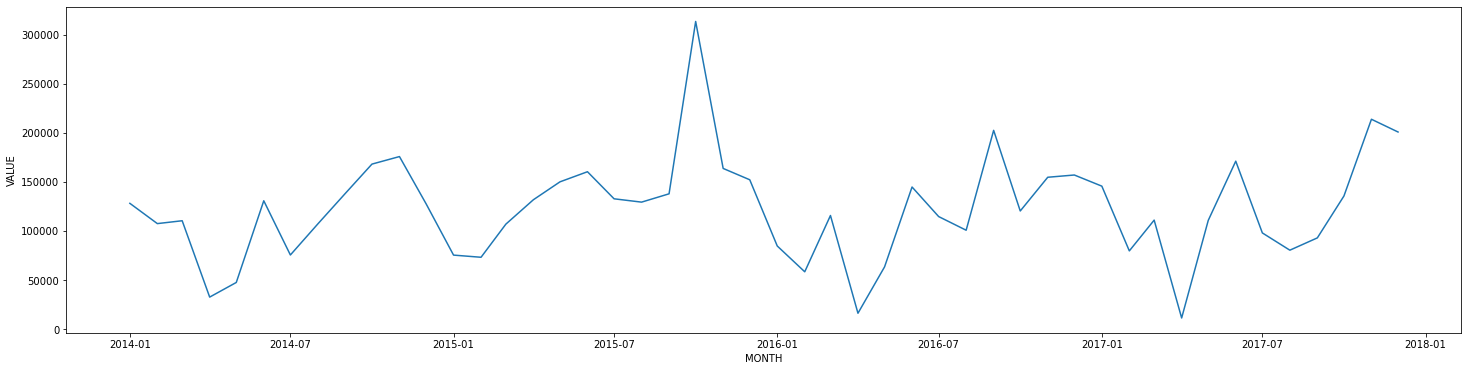

In [19]:
#Plot the data 
plt.figure(figsize=(25,6))
sns.lineplot(x="MONTH", y="VALUE", data=ABC_df_Pesticides,  ci= None)

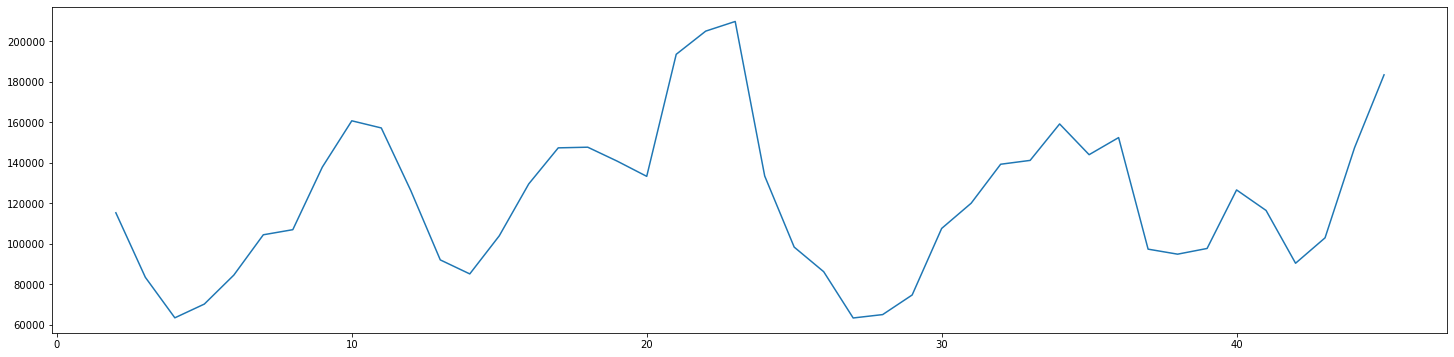

In [20]:
if consider_rolling_window == True:
    xyzseries = ABC_df_Pesticides['VALUE'].rolling(window = rolling_period)
    XYZmean = xyzseries.mean()
    plt.figure(figsize=(25,6))
    sns.lineplot( data=XYZmean,  ci= None)
    

In [21]:
XYZmean

0            NaN
1            NaN
2     115282.935
3      83449.215
4      63467.775
5      70248.195
6      84546.000
7     104433.930
8     106950.105
9     137808.090
10    160662.870
11    157137.615
12    126236.565
13     92046.195
14     85128.120
15    103921.020
16    129530.565
17    147318.255
18    147642.615
19    140753.745
20    133256.520
21    193465.800
22    204905.250
23    209671.245
24    133442.100
25     98353.440
26     86225.805
27     63391.545
28     65060.370
29     74734.830
30    107557.200
31    119999.430
32    139234.230
33    141130.395
34    159113.295
35    143949.825
36    152381.610
37    127383.045
38    112066.950
37     67309.230
38     77670.780
39     97683.885
40    126559.170
41    116436.555
42     90392.355
43    102934.260
44    147385.620
45    183335.130
Name: VALUE, dtype: float64

[Text(0, 0, 'VALUE')]

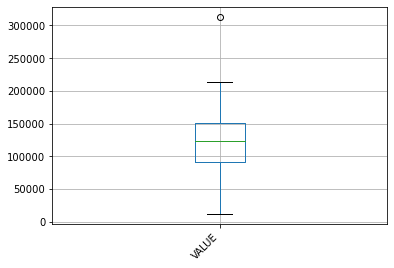

In [22]:
boxplot = ABC_df_Pesticides.boxplot(column=['VALUE'])
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [23]:
ABC_df_Pesticides.describe()

VALUE
count      48.000000
mean   122038.500000
std     53317.253039
min     11309.085000
25%     90822.262500
50%    123971.917500
75%    150494.321250
max    313321.500000

In [24]:
print(ABC_df_Pesticides["VALUE"].quantile(0.95))

201827.76750000007


In [25]:
#ABC_df_Pesticides["VALUE"]=np.where(ABC_df_Pesticides["VALUE"]>66082.66875,66082.66875,ABC_df_Pesticides["VALUE"])

In [26]:
if consider_rolling_window == True:
    ABC_df_Pesticides['VALUE'] = XYZmean
    ABC_df_Pesticides = ABC_df_Pesticides[rolling_period - 1:]


# Check for Stationarity and Seasonality

In [27]:
# for a time series to be Sationary
# 1. Mean has to be constant 
# 2. variance has to be constant 
# 3. No seasonality

# If a timeseries has seasonality, then it is not stationary. i.e ARMA models cannot be run.

In [28]:
# Augmented Dickey FULLER test to check Stationarity

def ADF_test(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [29]:
ADF_test(ABC_df_Pesticides['VALUE'])

Test statistic = -4.192
P-value = 0.001
Critical values :
	1%: -3.6055648906249997 - The data is  stationary with 99% confidence
	5%: -2.937069375 - The data is  stationary with 95% confidence
	10%: -2.606985625 - The data is  stationary with 90% confidence


In [30]:
# from the above result, as p-value < 0.05... we can conclude that the timeseries data is Stationary

In [31]:
# Additional check using KPSS method   [ Kwiatkowski–Phillips–Schmidt–Shin (KPSS)]
# Ref: https://www.statisticshowto.com/kpss-test/

stats, p, lags, critical_values = kpss(ABC_df_Pesticides['VALUE'],'c')
stats, p, lags, critical_values

print(f'Test Statistics: {stats}')
print(f'p value: {p}')
print(f'critical_values: {critical_values}')



Test Statistics: 0.1469793350568254
p value: 0.1
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [32]:
# as 0.1  is greater than 0.05, we can conclude that the timeseries data is Stationary

In [33]:
ABC_df_Pesticides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 2 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MONTH   46 non-null     object 
 1   VALUE   46 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [34]:
# Reset index after converting 'Month' to Datetime
ABC_df_Pesticides['MONTH'] = pd.to_datetime(ABC_df_Pesticides['MONTH'])
ABC_df_Pesticides.set_index('MONTH', inplace=True)

In [35]:
ABC_df_Pesticides

VALUE
MONTH                 
2014-03-01  115282.935
2014-04-01   83449.215
2014-05-01   63467.775
2014-06-01   70248.195
2014-07-01   84546.000
2014-08-01  104433.930
2014-09-01  106950.105
2014-10-01  137808.090
2014-11-01  160662.870
2014-12-01  157137.615
2015-01-01  126236.565
2015-02-01   92046.195
2015-03-01   85128.120
2015-04-01  103921.020
2015-05-01  129530.565
2015-06-01  147318.255
2015-07-01  147642.615
2015-08-01  140753.745
2015-09-01  133256.520
2015-10-01  193465.800
2015-11-01  204905.250
2015-12-01  209671.245
2016-01-01  133442.100
2016-02-01   98353.440
2016-03-01   86225.805
2016-04-01   63391.545
2016-05-01   65060.370
2016-06-01   74734.830
2016-07-01  107557.200
2016-08-01  119999.430
2016-09-01  139234.230
2016-10-01  141130.395
2016-11-01  159113.295
2016-12-01  143949.825
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

<Figure size 2160x2520 with 0 Axes>

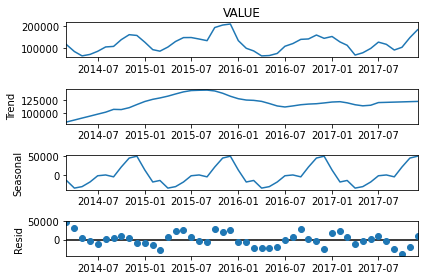

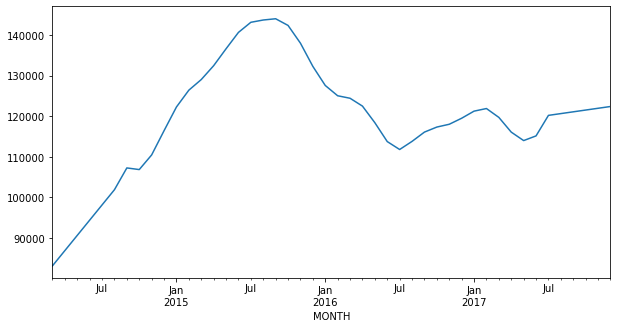

In [36]:
res = sm.tsa.seasonal_decompose(ABC_df_Pesticides['VALUE'],model = 'additive',extrapolate_trend='freq')

plt.figure(figsize=(30,35))
resplot = res.plot(observed=True)

plt.figure(figsize=(10, 5))
res.trend.plot()

# FBProphet Model

In [37]:
ABC_df_Pesticides_FBP =  ABC_df_Pesticides.copy(deep=True)

In [38]:
ABC_df_Pesticides_FBP = ABC_df_Pesticides_FBP.reset_index()[['MONTH','VALUE']].rename({'MONTH':'ds','VALUE':'y'}, axis='columns')

In [39]:
train = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] <= pd.to_datetime(train_end_date)]
train

ds           y
0  2014-03-01  115282.935
1  2014-04-01   83449.215
2  2014-05-01   63467.775
3  2014-06-01   70248.195
4  2014-07-01   84546.000
5  2014-08-01  104433.930
6  2014-09-01  106950.105
7  2014-10-01  137808.090
8  2014-11-01  160662.870
9  2014-12-01  157137.615
10 2015-01-01  126236.565
11 2015-02-01   92046.195
12 2015-03-01   85128.120
13 2015-04-01  103921.020
14 2015-05-01  129530.565
15 2015-06-01  147318.255
16 2015-07-01  147642.615
17 2015-08-01  140753.745
18 2015-09-01  133256.520
19 2015-10-01  193465.800
20 2015-11-01  204905.250
21 2015-12-01  209671.245
22 2016-01-01  133442.100
23 2016-02-01   98353.440
24 2016-03-01   86225.805
25 2016-04-01   63391.545
26 2016-05-01   65060.370
27 2016-06-01   74734.830
28 2016-07-01  107557.200
29 2016-08-01  119999.430
30 2016-09-01  139234.230
31 2016-10-01  141130.395
32 2016-11-01  159113.295
33 2016-12-01  143949.825

In [40]:
test = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] > pd.to_datetime(train_end_date)]
test

ds           y
34 2017-01-01  152381.610
35 2017-02-01  127383.045
36 2017-03-01  112066.950
37 2017-04-01   67309.230
38 2017-05-01   77670.780
39 2017-06-01   97683.885
40 2017-07-01  126559.170
41 2017-08-01  116436.555
42 2017-09-01   90392.355
43 2017-10-01  102934.260
44 2017-11-01  147385.620
45 2017-12-01  183335.130

In [41]:
test.rename({'ds' : 'MONTH','y' : 'VALUE'},axis=1,inplace=True)
test.set_index('MONTH', inplace=True)

In [42]:
test

VALUE
MONTH                 
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

In [43]:
#run the model with confidence interval of 95%
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [44]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
m.params

{'k': array([[0.05790016]]),
 'm': array([[0.50590126]]),
 'delta': array([[ 1.19612768e-10,  1.40040373e-11,  9.68493345e-11,
         -7.48009486e-11, -1.70858514e-10,  5.01656976e-11,
         -1.87801201e-10, -1.28132764e-10, -1.53449774e-10,
          4.03699170e-11,  1.06673695e-11, -1.80409853e-04,
         -1.09963178e-05, -4.78470830e-04, -7.44998072e-04,
         -8.24069631e-04, -7.56481052e-04, -5.59363944e-04,
         -2.26936952e-04, -2.68577567e-05, -1.54378536e-04,
         -4.57091853e-05,  4.80528651e-11,  4.33561959e-11,
         -4.47764980e-11]]),
 'sigma_obs': array([[0.09174841]]),
 'beta': array([[-0.2274546 ,  0.0327053 ,  0.33396679, -1.12625217,  0.27188838,
         -0.35626678,  0.01178675, -0.19012478,  0.02961814, -0.26774935,
          0.4303686 ,  0.05350445,  0.02618381,  0.32526471,  0.01986853,
          0.21586114,  0.30366126,  0.29081764,  0.24667787,  1.17309033]]),
 'trend': array([[0.50590126, 0.50768546, 0.50941211, 0.51119631, 0.51292295,
  

In [46]:
future = m.make_future_dataframe(periods=predict_periods,freq='MS')

In [47]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds           yhat     yhat_lower     yhat_upper
0  2014-03-01   90617.142075   52841.757001  132279.589060
1  2014-04-01   81301.593458   45167.847709  121246.916158
2  2014-05-01   84459.625167   46473.903218  119506.663072
3  2014-06-01   95837.786774   55274.848341  129547.722298
4  2014-07-01  107763.678848   69877.831309  143729.264358
5  2014-08-01  114849.069716   77245.358888  149057.113565
6  2014-09-01  116882.635990   79884.996922  154381.812974
7  2014-10-01  154979.240668  114218.198168  192124.615924
8  2014-11-01  173353.650987  134001.932650  211056.522387
9  2014-12-01  172326.099779  134659.620118  211112.191365
10 2015-01-01  132461.139044   92724.297932  172777.553764
11 2015-02-01  101310.068707   63727.110690  142169.022275
12 2015-03-01   94379.301242   58913.883207  132879.332632
13 2015-04-01   92475.904896   55540.037500  129293.577522
14 2015-05-01   97016.982032   60969.120407  134106.983943
15 2015-06-01  107427.321759   68898.578643  145119.449432
16 2015-07-01  107597.785370   68679.200873  144743.090399
17 2015-08-01  110980.423534   71300.845957  149998.652116
18 2015-09-01  106135.495460   72068.158284  144530.706693
19 2015-10-01  166225.186662  130527.185344  204574.712036
20 2015-11-01  186546.876328  151104.943612  221897.588800
21 2015-12-01  194486.770555  156150.588028  231112.870391
22 2016-01-01  127219.992043   87972.443076  165991.516974
23 2016-02-01   89211.176653   51026.340614  129559.957103
24 2016-03-01  101785.713341   66168.724347  140040.744558
25 2016-04-01   77221.699854   41772.287675  115694.813735
26 2016-05-01   76741.387286   39471.637653  114324.764531
27 2016-06-01   89224.410840   51225.976552  126170.343502
28 2016-07-01  124398.121284   83656.887402  159202.660893
29 2016-08-01  139384.156489   99633.100746  176487.870994
30 2016-09-01  156461.186275  120976.871649  195103.629667
31 2016-10-01  151066.111082  115446.594918  186298.354921
32 2016-11-01  164671.914327  124989.310021  203567.404503
33 2016-12-01  143858.407491  104582.074638  178519.653128
34 2017-01-01  158121.293882  120645.135019  195851.052199
35 2017-02-01  142308.350041  101866.645828  179736.805270
36 2017-03-01  104421.939257   65776.336027  140621.481662
37 2017-04-01   87530.771569   48593.367259  124408.380425
38 2017-05-01   88996.204817   51409.590806  127909.069030
39 2017-06-01  101048.789918   63984.345014  138866.337875
40 2017-07-01  124630.112792   87000.908960  163706.663124
41 2017-08-01  135566.241087   97895.286026  173204.121272
42 2017-09-01  144886.319374  102576.584205  182694.989302
43 2017-10-01  161122.738240  123680.653012  197116.466395
44 2017-11-01  177230.025541  140879.108029  212117.554412
45 2017-12-01  166592.198328  132100.425011  203267.789637

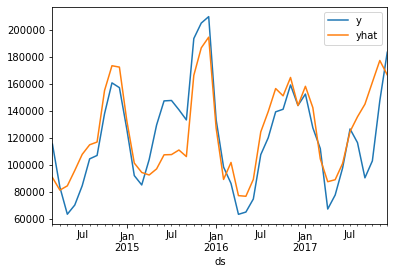

In [48]:
pd.concat([ABC_df_Pesticides_FBP.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

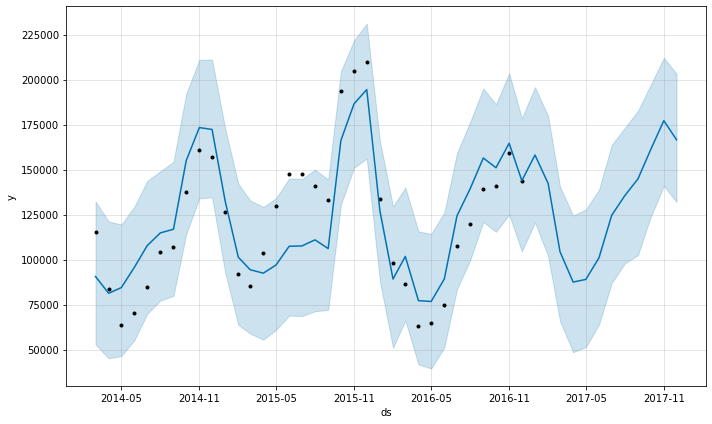

In [49]:
fig1 = m.plot(forecast)

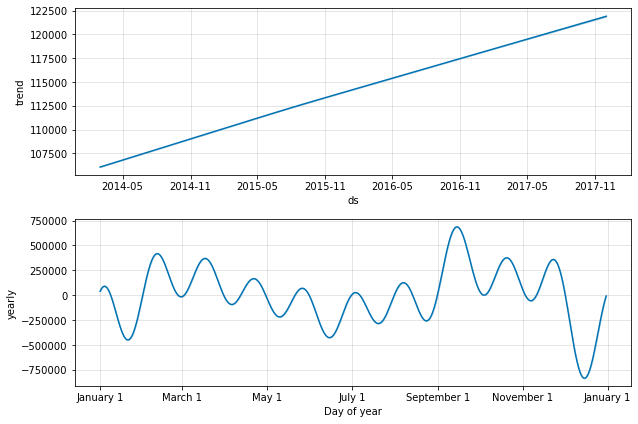

In [50]:
fig2 = m.plot_components(forecast)

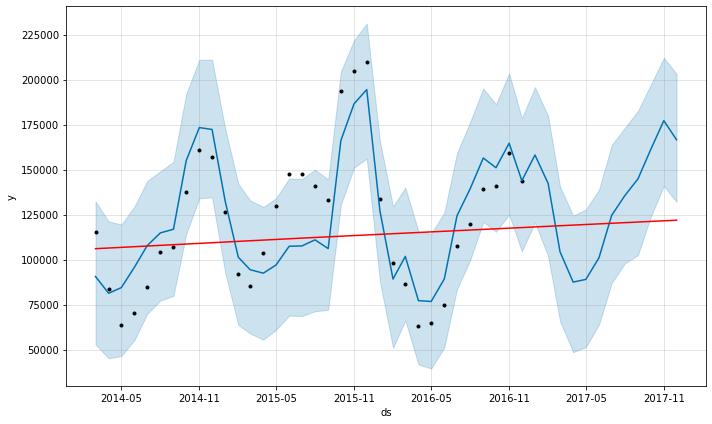

In [51]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [52]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [53]:
#check for cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '120 days')
cv_results

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-04-05 00:00:00 and 2016-08-03 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


ds           yhat     yhat_lower     yhat_upper           y  \
0  2016-05-01  143755.736376  112482.067727  175345.185102   65060.370   
1  2016-06-01  129098.425859   98735.616742  163058.322398   74734.830   
2  2016-07-01  159517.808450  130162.099938  190877.024159  107557.200   
3  2016-08-01  211050.610465  176727.305902  243184.201439  119999.430   
4  2016-07-01  197304.401538  165074.763256  232108.225401  107557.200   
5  2016-08-01  225604.494650  190613.088310  257501.639349  119999.430   
6  2016-09-01  209234.892210  179409.995989  240631.596015  139234.230   
7  2016-10-01  143545.632634  109567.042545  173234.865933  141130.395   
8  2016-09-01  260288.538514  226445.319221  296942.136017  139234.230   
9  2016-10-01  166046.058554  129045.302736  202613.252350  141130.395   
10 2016-11-01  152249.640867  114268.456719  189917.899139  159113.295   
11 2016-12-01  103541.577893   68630.305836  136559.684084  143949.825   

       cutoff  
0  2016-04-05  
1  2016-04-05  
2  2016-04-05  
3  2016-04-05  
4  2016-06-04  
5  2016-06-04  
6  2016-06-04  
7  2016-06-04  
8  2016-08-03  
9  2016-08-03  
10 2016-08-03  
11 2016-08-03

In [54]:
#Check performance metrics
df_p = performance_metrics(cv_results)
df_p

horizon           mse           rmse            mae      mape     mdape  \
0   26 days  6.192961e+09   78695.366376   78695.366376  1.209575  1.209575   
1   27 days  8.054560e+09   89747.201538   89747.201538  0.834414  0.834414   
2   29 days  1.465415e+10  121054.308514  121054.308514  0.869429  0.869429   
3   57 days  2.955401e+09   54363.595859   54363.595859  0.727420  0.727420   
4   58 days  1.115243e+10  105605.064650  105605.064650  0.880046  0.880046   
5   59 days  6.207903e+08   24915.663554   24915.663554  0.176544  0.176544   
6   87 days  2.699905e+09   51960.608450   51960.608450  0.483097  0.483097   
7   89 days  4.900093e+09   70000.662210   70000.662210  0.502755  0.502755   
8   90 days  4.710975e+07    6863.654133    6863.654133  0.043137  0.043137   
9  118 days  8.290317e+09   91051.180465   91051.180465  0.758763  0.758763   
10 119 days  5.833373e+06    2415.237634    2415.237634  0.017114  0.017114   
11 120 days  1.632826e+09   40408.247107   40408.247107  0.280711  0.280711   

    coverage  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        1.0  
6        0.0  
7        0.0  
8        1.0  
9        0.0  
10       1.0  
11       0.0

In [55]:
forecast_FBP = forecast.loc[forecast['ds'] > pd.to_datetime(train_end_date)]
forecast_FBP.rename(columns={ 'ds' : 'MONTH'},inplace = True)
forecast_FBP['MONTH'] = pd.to_datetime(forecast_FBP['MONTH'])
forecast_FBP.set_index('MONTH', inplace=True)
forecast_FBP.drop(columns =['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper'], axis = 1, inplace = True)

In [56]:
forecast_FBP

yhat
MONTH                    
2017-01-01  158121.293882
2017-02-01  142308.350041
2017-03-01  104421.939257
2017-04-01   87530.771569
2017-05-01   88996.204817
2017-06-01  101048.789918
2017-07-01  124630.112792
2017-08-01  135566.241087
2017-09-01  144886.319374
2017-10-01  161122.738240
2017-11-01  177230.025541
2017-12-01  166592.198328

In [57]:
ABC_df_Pesticides_FBP_residue = ABC_df_Pesticides_FBP.loc[forecast['ds'] > pd.to_datetime(train_end_date)]

ABC_df_Pesticides_FBP_residue.rename(columns={ 'ds' : 'MONTH', 'y' : 'VALUE'},inplace = True)
ABC_df_Pesticides_FBP_residue.set_index('MONTH', inplace=True)

In [58]:
residual_FBP = ABC_df_Pesticides_FBP_residue['VALUE'] - forecast_FBP['yhat']
residual_FBP

MONTH
2017-01-01    -5739.683882
2017-02-01   -14925.305041
2017-03-01     7645.010743
2017-04-01   -20221.541569
2017-05-01   -11325.424817
2017-06-01    -3364.904918
2017-07-01     1929.057208
2017-08-01   -19129.686087
2017-09-01   -54493.964374
2017-10-01   -58188.478240
2017-11-01   -29844.405541
2017-12-01    16742.931672
dtype: float64

In [59]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual_FBP**2)))

Root Mean Squared Error: 27016.700196824073


In [60]:
print(mean_absolute_error(test.loc[pd.to_datetime(test_start_date)] ,forecast_FBP.loc[pd.to_datetime(test_start_date)]))

5739.683882052457


In [61]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_FBP.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

19.54375075351472

# Auto Arima

In [62]:
ABC_df_Pesticides_AA = ABC_df_Pesticides.copy(deep=True)

In [63]:
model = pm.auto_arima(ABC_df_Pesticides_AA['VALUE'], m = predict_periods,seasonal= True,start_P= 0,start_q= 0,max_order= 4,test = 'adf',
                     error_action= 'ignore',suppress_warnings= True,stepwise= True,trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=1031.964, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1028.489, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1030.397, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1029.521, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1030.903, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1030.479, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1028.569, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1027.773, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1029.483, Time=0.05 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1030.709, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1030.714, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1022.627, Time=0.04 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=1024.224, Time=0.08 sec
 ARIMA(0,2,2)(0,0,1)[12]

In [64]:
#Model suumary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -508.314
Date:                Thu, 24 Jun 2021   AIC                           1022.627
Time:                        15:33:59   BIC                           1027.980
Sample:                             0   HQIC                          1024.612
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6367      0.278     -2.289      0.022      -1.182      -0.091
ma.L2         -0.3214      0.301     -1.069      0.285      -0.911       0.268
sigma2      8.427e+08   1.91e-10    4.4e+18      0.000    8.43e+08    8.43e+08
===================================================================================
Ljung-Box (Q):                       49.28   Jarque-Bera (JB):                10.28
Prob(Q):                              0.15   Prob(JB):                         0.01
Heteroskedasticity (H):               2.20   Skew:                            -0.63
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.12e+35. Standard errors may be unstable.
"""

In [65]:
ABC_df_Pesticides_AA

VALUE
MONTH                 
2014-03-01  115282.935
2014-04-01   83449.215
2014-05-01   63467.775
2014-06-01   70248.195
2014-07-01   84546.000
2014-08-01  104433.930
2014-09-01  106950.105
2014-10-01  137808.090
2014-11-01  160662.870
2014-12-01  157137.615
2015-01-01  126236.565
2015-02-01   92046.195
2015-03-01   85128.120
2015-04-01  103921.020
2015-05-01  129530.565
2015-06-01  147318.255
2015-07-01  147642.615
2015-08-01  140753.745
2015-09-01  133256.520
2015-10-01  193465.800
2015-11-01  204905.250
2015-12-01  209671.245
2016-01-01  133442.100
2016-02-01   98353.440
2016-03-01   86225.805
2016-04-01   63391.545
2016-05-01   65060.370
2016-06-01   74734.830
2016-07-01  107557.200
2016-08-01  119999.430
2016-09-01  139234.230
2016-10-01  141130.395
2016-11-01  159113.295
2016-12-01  143949.825
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

In [66]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_AA.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [67]:
train

VALUE
MONTH                 
2014-03-01  115282.935
2014-04-01   83449.215
2014-05-01   63467.775
2014-06-01   70248.195
2014-07-01   84546.000
2014-08-01  104433.930
2014-09-01  106950.105
2014-10-01  137808.090
2014-11-01  160662.870
2014-12-01  157137.615
2015-01-01  126236.565
2015-02-01   92046.195
2015-03-01   85128.120
2015-04-01  103921.020
2015-05-01  129530.565
2015-06-01  147318.255
2015-07-01  147642.615
2015-08-01  140753.745
2015-09-01  133256.520
2015-10-01  193465.800
2015-11-01  204905.250
2015-12-01  209671.245
2016-01-01  133442.100
2016-02-01   98353.440
2016-03-01   86225.805
2016-04-01   63391.545
2016-05-01   65060.370
2016-06-01   74734.830
2016-07-01  107557.200
2016-08-01  119999.430
2016-09-01  139234.230
2016-10-01  141130.395
2016-11-01  159113.295
2016-12-01  143949.825

In [68]:
test

VALUE
MONTH                 
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

In [69]:
#Fitting the model in the train set
model.fit(train['VALUE'])

ARIMA(order=(0, 2, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [70]:
#Forecasting the train model and comparing the value
forecast = model.predict(n_periods=predict_periods,return_conf_int=True)

In [71]:
#Printing the forecast values in the test set
forecast

(array([138316.08607356, 140761.24688625, 143206.40769893, 145651.56851161,
        148096.72932429, 150541.89013698, 152987.05094966, 155432.21176234,
        157877.37257502, 160322.53338771, 162767.69420039, 165212.85501307]),
 array([[  80693.95750287,  195938.21464426],
        [  41855.0480582 ,  239667.4457143 ],
        [  13116.54089344,  273296.27450442],
        [ -11747.28954846,  303050.42657169],
        [ -34569.07581472,  330762.5344633 ],
        [ -56174.92091598,  357258.70118993],
        [ -77014.710596  ,  382988.81249532],
        [ -97362.14413732,  408226.567662  ],
        [-117396.39503603,  433151.14018608],
        [-137241.02549564,  457886.09227105],
        [-156984.6141218 ,  482520.00252258],
        [-176692.58136072,  507118.29138686]]))

In [72]:
#Resttin the forecast df to and creating the column name for prediction
forecast_df=pd.DataFrame(forecast[0],index= test.index,columns=['Prediction'])

In [73]:
#Printing the dataframe for forecast_dfABC_df
forecast_df

Prediction
MONTH                    
2017-01-01  138316.086074
2017-02-01  140761.246886
2017-03-01  143206.407699
2017-04-01  145651.568512
2017-05-01  148096.729324
2017-06-01  150541.890137
2017-07-01  152987.050950
2017-08-01  155432.211762
2017-09-01  157877.372575
2017-10-01  160322.533388
2017-11-01  162767.694200
2017-12-01  165212.855013

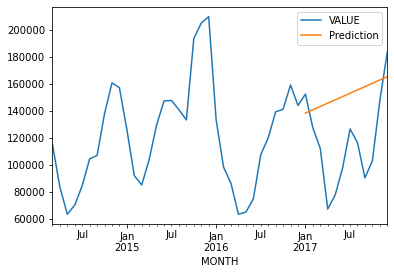

In [74]:
#Conactenating the observed and forecast model and plotting the graph
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast_df],axis=1).plot()

In [75]:
forecast1 = model.predict(n_periods=predict_periods,return_conf_int=True)
forecast1

(array([138316.08607356, 140761.24688625, 143206.40769893, 145651.56851161,
        148096.72932429, 150541.89013698, 152987.05094966, 155432.21176234,
        157877.37257502, 160322.53338771, 162767.69420039, 165212.85501307]),
 array([[  80693.95750287,  195938.21464426],
        [  41855.0480582 ,  239667.4457143 ],
        [  13116.54089344,  273296.27450442],
        [ -11747.28954846,  303050.42657169],
        [ -34569.07581472,  330762.5344633 ],
        [ -56174.92091598,  357258.70118993],
        [ -77014.710596  ,  382988.81249532],
        [ -97362.14413732,  408226.567662  ],
        [-117396.39503603,  433151.14018608],
        [-137241.02549564,  457886.09227105],
        [-156984.6141218 ,  482520.00252258],
        [-176692.58136072,  507118.29138686]]))

In [76]:
forecast_range=pd.date_range(start= pd.to_datetime(test_start_date) ,periods= predict_periods,freq='MS')
forecast_range

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [77]:
forecast1_df = pd.DataFrame(forecast1[0],index= forecast_range,columns=['Prediction'])

In [78]:
forecast1_df

Prediction
2017-01-01  138316.086074
2017-02-01  140761.246886
2017-03-01  143206.407699
2017-04-01  145651.568512
2017-05-01  148096.729324
2017-06-01  150541.890137
2017-07-01  152987.050950
2017-08-01  155432.211762
2017-09-01  157877.372575
2017-10-01  160322.533388
2017-11-01  162767.694200
2017-12-01  165212.855013

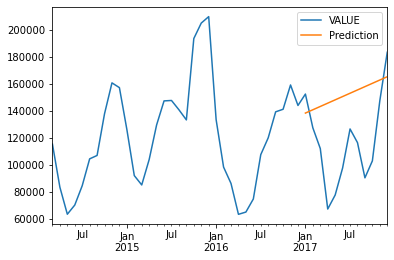

In [79]:
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast1_df],axis=1).plot()

In [80]:
lower = pd.Series(forecast1[1][:,0],index=forecast_range)
upper = pd.Series(forecast1[1][:,1],index=forecast_range)

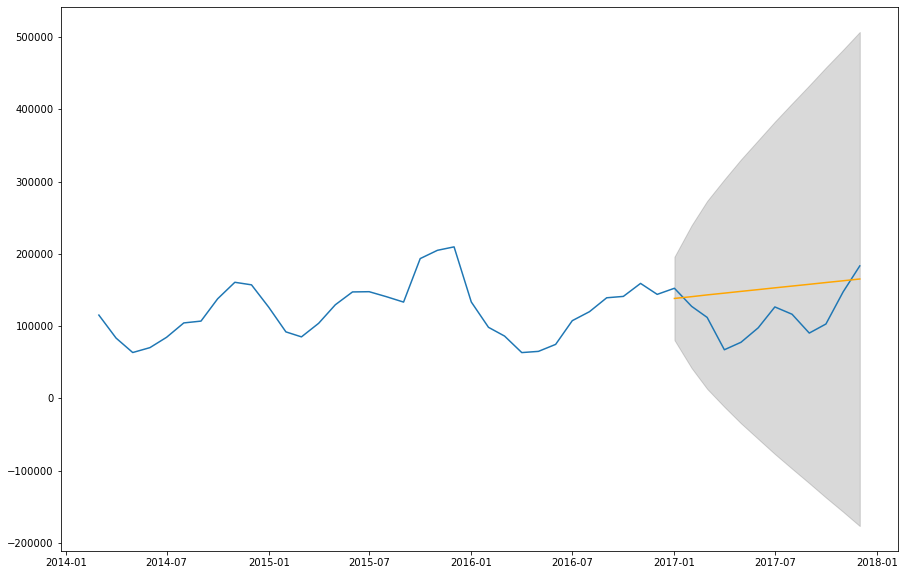

In [81]:
plt.figure(figsize=(15,10))
plt.plot(ABC_df_Pesticides_AA['VALUE'])
plt.plot(forecast1_df,color = 'orange')
plt.fill_between(forecast_range,lower,upper,color = 'k',alpha = .15)


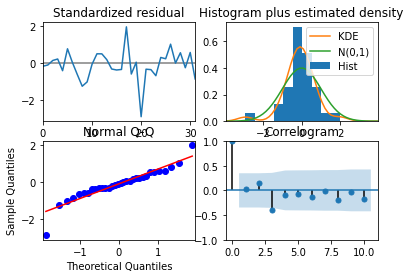

In [82]:
out = model.plot_diagnostics()

In [83]:
residuals_AA = test['VALUE'] - forecast_df['Prediction']
residuals_AA

MONTH
2017-01-01    14065.523926
2017-02-01   -13378.201886
2017-03-01   -31139.457699
2017-04-01   -78342.338512
2017-05-01   -70425.949324
2017-06-01   -52858.005137
2017-07-01   -26427.880950
2017-08-01   -38995.656762
2017-09-01   -67485.017575
2017-10-01   -57388.273388
2017-11-01   -15382.074200
2017-12-01    18122.274987
dtype: float64

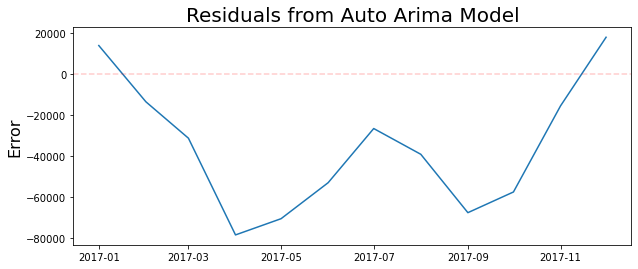

In [84]:
plt.figure(figsize=(10,4))
plt.plot(residuals_AA)
plt.title('Residuals from Auto Arima Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

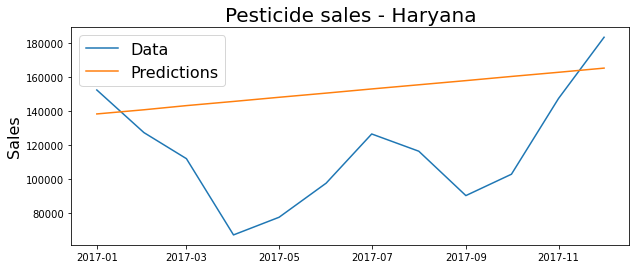

In [85]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(forecast_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Haryana', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [86]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_AA**2)))

Root Mean Squared Error: 46430.545655420814


In [87]:
print(mean_absolute_error(test['VALUE'] ,forecast_df['Prediction']))

40334.22119554504


In [88]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

42.81658333667928

# ARMA model

In [89]:
ABC_df_Pesticides_ARMA = ABC_df_Pesticides.copy(deep=True)

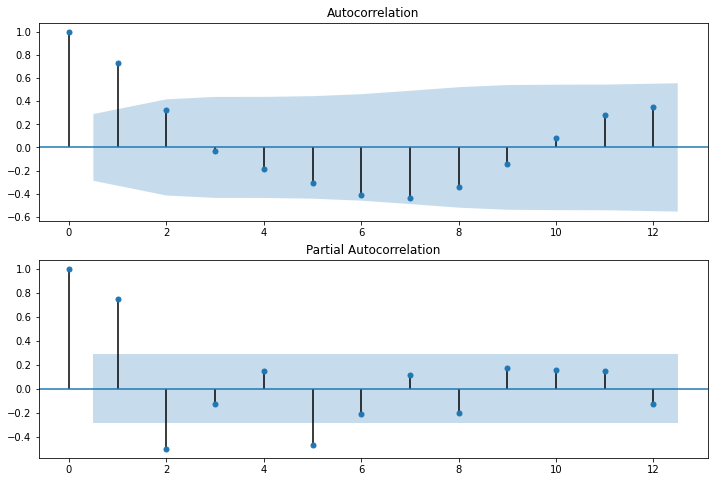

In [90]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax1)
ax2=fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax2)

In [91]:
train = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_ARMA.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [92]:
train

VALUE
MONTH                 
2014-03-01  115282.935
2014-04-01   83449.215
2014-05-01   63467.775
2014-06-01   70248.195
2014-07-01   84546.000
2014-08-01  104433.930
2014-09-01  106950.105
2014-10-01  137808.090
2014-11-01  160662.870
2014-12-01  157137.615
2015-01-01  126236.565
2015-02-01   92046.195
2015-03-01   85128.120
2015-04-01  103921.020
2015-05-01  129530.565
2015-06-01  147318.255
2015-07-01  147642.615
2015-08-01  140753.745
2015-09-01  133256.520
2015-10-01  193465.800
2015-11-01  204905.250
2015-12-01  209671.245
2016-01-01  133442.100
2016-02-01   98353.440
2016-03-01   86225.805
2016-04-01   63391.545
2016-05-01   65060.370
2016-06-01   74734.830
2016-07-01  107557.200
2016-08-01  119999.430
2016-09-01  139234.230
2016-10-01  141130.395
2016-11-01  159113.295
2016-12-01  143949.825

In [93]:
# define model
model = ARMA(train, order=(1,1))

In [94]:
model_fit = model.fit()

In [95]:
#summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  VALUE   No. Observations:                   34
Model:                     ARMA(1, 1)   Log Likelihood                -387.763
Method:                       css-mle   S.D. of innovations          21329.207
Date:                Thu, 24 Jun 2021   AIC                            783.527
Time:                        15:34:03   BIC                            789.632
Sample:                    03-01-2014   HQIC                           785.609
                         - 12-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.215e+05   1.45e+04      8.381      0.000    9.31e+04     1.5e+05
ar.L1.VALUE     0.6711      0.132      5.078      0.000       0.412       0.930
ma.L1.VALUE     0.3888      0.135      2.876    

In [96]:
test

VALUE
MONTH                 
2017-01-01  152381.610
2017-02-01  127383.045
2017-03-01  112066.950
2017-04-01   67309.230
2017-05-01   77670.780
2017-06-01   97683.885
2017-07-01  126559.170
2017-08-01  116436.555
2017-09-01   90392.355
2017-10-01  102934.260
2017-11-01  147385.620
2017-12-01  183335.130

In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALUE   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [98]:
#get the predictions and residuals
predictions = model_fit.predict(start=pd.to_datetime(test_start_date), end = pd.to_datetime(test_end_date))

In [99]:
predictions

2017-01-01    131805.342246
2017-02-01    128406.494494
2017-03-01    126125.619891
2017-04-01    124594.986768
2017-05-01    123567.820366
2017-06-01    122878.516834
2017-07-01    122415.943917
2017-08-01    122105.523770
2017-09-01    121897.209224
2017-10-01    121757.414978
2017-11-01    121663.602848
2017-12-01    121600.648071
Freq: MS, dtype: float64

In [100]:
Pred_range=pd.date_range(start = pd.to_datetime(test_end_date),periods= predict_periods,freq='MS')
Pred_range

DatetimeIndex(['2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01'],
              dtype='datetime64[ns]', freq='MS')

In [101]:
Pred_df = predictions.to_frame()
Pred_df.info()
Pred_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


0
2017-01-01  131805.342246
2017-02-01  128406.494494
2017-03-01  126125.619891
2017-04-01  124594.986768
2017-05-01  123567.820366
2017-06-01  122878.516834
2017-07-01  122415.943917
2017-08-01  122105.523770
2017-09-01  121897.209224
2017-10-01  121757.414978
2017-11-01  121663.602848
2017-12-01  121600.648071

In [102]:
Pred_df.columns = ['PRED_VALUE']

In [103]:
residuals_ARMA = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_ARMA

MONTH
2017-01-01    20576.267754
2017-02-01    -1023.449494
2017-03-01   -14058.669891
2017-04-01   -57285.756768
2017-05-01   -45897.040366
2017-06-01   -25194.631834
2017-07-01     4143.226083
2017-08-01    -5668.968770
2017-09-01   -31504.854224
2017-10-01   -18823.154978
2017-11-01    25722.017152
2017-12-01    61734.481929
dtype: float64

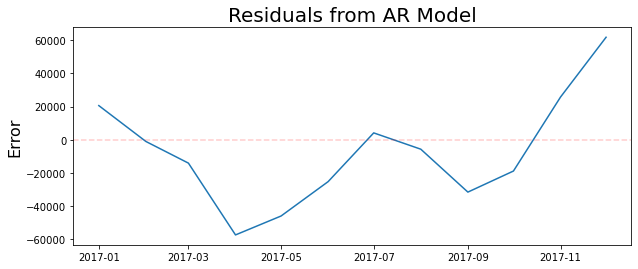

In [104]:
plt.figure(figsize=(10,4))
plt.plot(residuals_ARMA)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

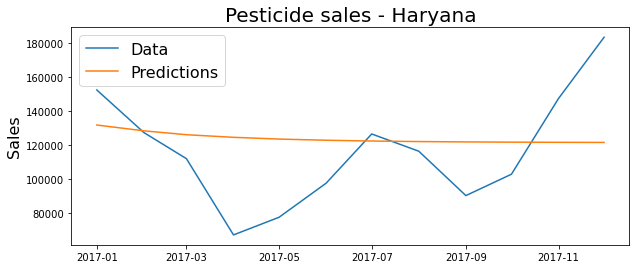

In [105]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(Pred_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Haryana', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [106]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_ARMA**2)))

Root Mean Squared Error: 32292.905717696594


In [107]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

25969.37660345143


In [108]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

25.770937629937883

# SARIMAX Model

In [109]:
ABC_df_Pesticides_SARIMAX = ABC_df_Pesticides.copy(deep=True)

In [110]:
p = range(0, 3)
d = range(0, 1)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[0], x[0], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
               
            continue            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1186.6696208109452
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1186.6696208109452
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1186.6696208109452
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:497.3962086205744
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:497.3962086205744
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:497.3962086205744
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4764.9624354474745
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4764.9624354474745
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4764.9624354474745
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:469.6630920792444
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:469.6630920792444
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:469.6630920792444
ARIMA(0, 0,

In [111]:
# Fitting the data to SARIMA model 
model = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX['VALUE'], 
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 2, 12),  
                                continueenforce_invertibility=False)

In [112]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0585   4491.400    1.3e-05      1.000   -8802.924    8803.041
ar.S.L24      -0.6760    1.3e+04  -5.19e-05      1.000   -2.55e+04    2.55e+04
ma.S.L12      -0.6057     46.756     -0.013      0.990     -92.245      91.034
ma.S.L24       0.2426   2.68e+04   9.05e-06      1.000   -5.26e+04    5.26e+04
sigma2      5.165e+09      0.266   1.95e+10      0.000    5.16e+09    5.16e+09


In [113]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         VALUE   No. Observations:                   46
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood                -272.053
Date:                       Thu, 24 Jun 2021   AIC                            554.106
Time:                               15:34:21   BIC                            559.561
Sample:                           03-01-2014   HQIC                           555.391
                                - 12-01-2017                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0585   4491.400    1.3e-05      1.000   -8802.924    8803.041
ar.S.L24      -0.6760    1.3e+04  -5.19e-05      1.000   -2.55e+04    2.55e+04
ma.S.L12      -0.6057     46.756     -0.013      0.990     -92.245      91.034
ma.S.L24       0.2426   2.68e+04   9.05e-06      1.000   -5.26e+04    5.26e+04
sigma2      5.165e+09      0.266   1.95e+10      0.000    5.16e+09    5.16e+09
===================================================================================
Ljung-Box (Q):                       43.55   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.00   Prob(JB):                         0.58
Heteroskedasticity (H):               0.68   Skew:                            -0.02
Prob(H) (two-sided):                  0.63   Kurtosis:                         1.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.85e+26. Standard errors may be unstable.
"""

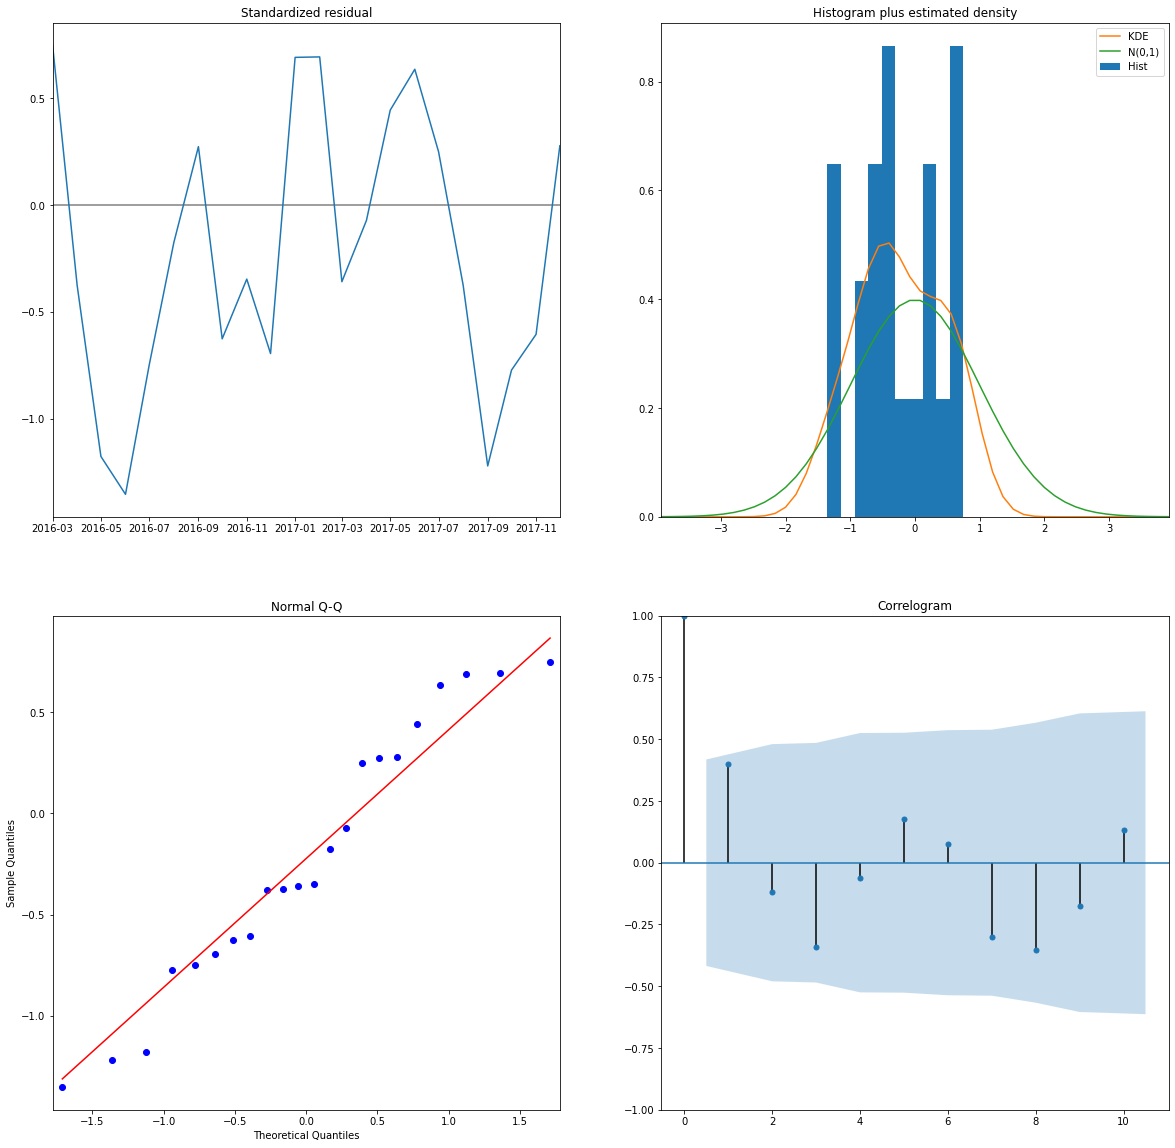

In [114]:
# Checking diagnostic plots
results.plot_diagnostics(figsize=(20, 20))
plt.show()

In [115]:
train = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_SARIMAX.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [116]:
forecast = results.predict(n_periods=predict_periods,return_conf_int=True)
forecast

2014-03-01    0.000000e+00
2014-04-01   -1.291597e-10
2014-05-01   -1.467131e-10
2014-06-01   -2.272191e-11
2014-07-01   -4.811348e-11
2014-08-01   -2.289185e-10
2014-09-01   -2.464381e-10
2014-10-01   -1.865210e-10
2014-11-01   -2.680393e-10
2014-12-01   -3.743541e-10
2015-01-01   -4.132065e-10
2015-02-01   -1.927227e-10
2015-03-01    2.082501e+05
2015-04-01    1.507448e+05
2015-05-01    1.146498e+05
2015-06-01    1.268982e+05
2015-07-01    1.527261e+05
2015-08-01    1.886522e+05
2015-09-01    1.931975e+05
2015-10-01    2.489401e+05
2015-11-01    2.902256e+05
2015-12-01    2.838575e+05
2016-01-01    2.280370e+05
2016-02-01    1.662746e+05
2016-03-01    2.889873e+04
2016-04-01    9.223798e+04
2016-05-01    1.552851e+05
2016-06-01    1.785339e+05
2016-07-01    1.648638e+05
2016-08-01    1.334735e+05
2016-09-01    1.183309e+05
2016-10-01    1.891628e+05
2016-11-01    1.857247e+05
2016-12-01    1.972657e+05
2017-01-01    9.946643e+04
2017-02-01    7.430246e+04
2017-03-01    1.380012e+05
2

In [117]:
Predicted_df = pd.DataFrame(forecast.loc[forecast.index.isin(test.index)], columns=["PRED_VALUE"])
Predicted_df

PRED_VALUE
2017-01-01   99466.429361
2017-02-01   74302.459431
2017-03-01  138001.238835
2017-04-01   72538.514445
2017-05-01   45668.356883
2017-06-01   51879.824895
2017-07-01  108630.503715
2017-08-01  143533.122179
2017-09-01  178532.297388
2017-10-01  158720.596191
2017-11-01  191092.671098
2017-12-01  163362.480042

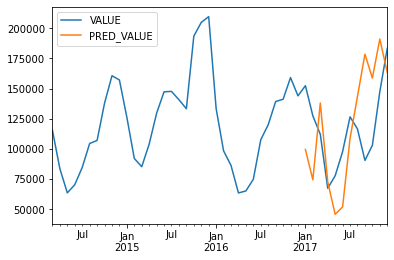

In [118]:
pd.concat([ABC_df_Pesticides_SARIMAX['VALUE'], Predicted_df], axis=1).plot()

In [119]:
residuals_SARIMAX = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_SARIMAX

MONTH
2017-01-01    20576.267754
2017-02-01    -1023.449494
2017-03-01   -14058.669891
2017-04-01   -57285.756768
2017-05-01   -45897.040366
2017-06-01   -25194.631834
2017-07-01     4143.226083
2017-08-01    -5668.968770
2017-09-01   -31504.854224
2017-10-01   -18823.154978
2017-11-01    25722.017152
2017-12-01    61734.481929
dtype: float64

In [120]:
#get the predictions

predict_future = results.forecast(len(test))
predict_future

2018-01-01    209301.711621
2018-02-01    175920.929122
2018-03-01    146172.752097
2018-04-01    112084.201946
2018-05-01    144393.319063
2018-06-01    177488.317266
2018-07-01    195682.201139
2018-08-01    166017.637999
2018-09-01    109981.341954
2018-10-01    162151.784779
2018-11-01    219339.767189
2018-12-01    285333.415011
Freq: MS, dtype: float64

In [121]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_SARIMAX**2)))

Root Mean Squared Error: 32292.905717696594


In [122]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

25969.37660345143


In [123]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

25.770937629937883

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [124]:
ABC_df_Pesticides_hwm =  ABC_df_Pesticides.copy(deep=True)

In [125]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [126]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_hwm.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [127]:
pred1 = ExponentialSmoothing(np.asarray(train['VALUE']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_slope'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_slope'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')

### Forecast for next 12 months

y_pred1 =  pred1.forecast(steps = 12)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['VALUE']})
print(df_pred1)


== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  0.9999
Smoothing Slope:  0.0526
Smoothing Seasonal:  0.0001
Initial Level:  95545.62
Initial Slope:  2952.2166
Initial Seasons:  [ 19737.315 -12096.405 -32077.845 -25297.425 -10999.62    8888.31
  11404.485  42262.47   65117.25   61591.995  30690.945  -3499.425]

                    Y_hat           Y
MONTH                                
2017-01-01  112183.233183  152381.610
2017-02-01   77136.270974  127383.045
2017-03-01   99504.972242  112066.950
2017-04-01   66822.837443   67309.230
2017-05-01   45980.555737   77670.780
2017-06-01   51894.012702   97683.885
2017-07-01   65329.550801  126559.170
2017-08-01   84352.323043  116436.555
2017-09-01   86011.513136   90392.355
2017-10-01  116007.562850  102934.260
2017-11-01  137999.405599  147385.620
2017-12-01  133615.397633  183335.130


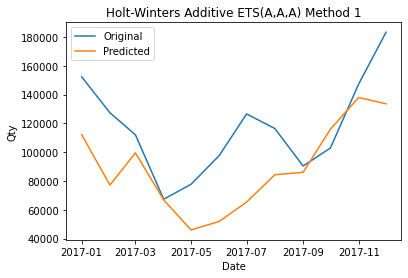

In [128]:
### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred1.Y, label='Original')
ax.plot(df_pred1.Y_hat, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [129]:
residuals_hwm = df_pred1.Y - df_pred1.Y_hat
residuals_hwm


MONTH
2017-01-01    40198.376817
2017-02-01    50246.774026
2017-03-01    12561.977758
2017-04-01      486.392557
2017-05-01    31690.224263
2017-06-01    45789.872298
2017-07-01    61229.619199
2017-08-01    32084.231957
2017-09-01     4380.841864
2017-10-01   -13073.302850
2017-11-01     9386.214401
2017-12-01    49719.732367
dtype: float64

In [130]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_hwm**2)))

Root Mean Squared Error: 35270.8453947657


In [131]:
print(mean_absolute_error(df_pred1.Y, df_pred1.Y_hat))

29237.296696350404


In [132]:

mape    =  p_mean_absolute_percentage_error(df_pred1.Y, df_pred1.Y_hat)

print("For alpha = %1.2f, MAPE is %3.2f" %(alpha_value, mape))

For alpha = 1.00, MAPE is 24.37


In [133]:
#Future forecast
final_model = ExponentialSmoothing(ABC_df_Pesticides_hwm['VALUE'], trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit()

In [134]:
pred=final_model.forecast(12)
pred

2018-01-01    153636.244692
2018-02-01    120653.782524
2018-03-01    145085.394567
2018-04-01    114473.758043
2018-05-01     95703.596506
2018-06-01    103682.904202
2018-07-01    119186.235532
2018-08-01    140272.205148
2018-09-01    143999.433204
2018-10-01    176064.385681
2018-11-01    200128.035803
2018-12-01    197808.239528
Freq: MS, dtype: float64

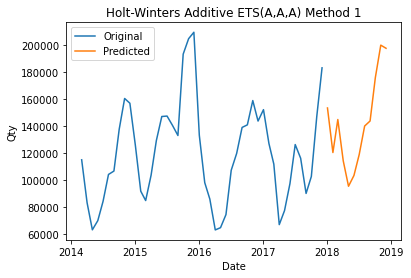

In [135]:
### Plot

fig2, ax = plt.subplots()
ax.plot(ABC_df_Pesticides_hwm['VALUE'], label='Original')
ax.plot(pred, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

# To check if Rainfall has any effect on Insecticides sales

In [136]:
Rainfall = [12.9,16.7,26.5,7.5, 20,25.8,71,33.5,67,10.8,0.2,9.4,12.1,6.6,70.7,34.9,8.3,43.5,127.9,84.4,32,3.8,2.3,0.2,
            0,1.1,20.7,0.6,26.8,34.8,155.1,133.8,13.7,5.2,0,0.9,33.8,0.3,7.2,3.7,10.1,121.8,67.7,74.7,91.8,0,1.8,4.2]

In [137]:
ABC_df_Pesticides['Rainfall'] = Rainfall[rolling_period - 1:]

Text(0, 0.5, 'Sales')

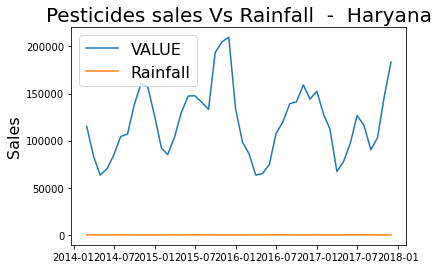

In [138]:
plt.plot(ABC_df_Pesticides)

plt.legend(('VALUE', 'Rainfall'), fontsize=16)

plt.title('Pesticides sales Vs Rainfall  -  Haryana', fontsize=20)
plt.ylabel('Sales', fontsize=16)

#Feature scaling for 'VALUE' column as Rainfall column

In [139]:
#Taking Rainfall and Value column on a common scale
ABC_df_Pesticides['VALUE'] = ABC_df_Pesticides['VALUE']/10000

In [140]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B7ADFE0D90>,
      dtype=object)

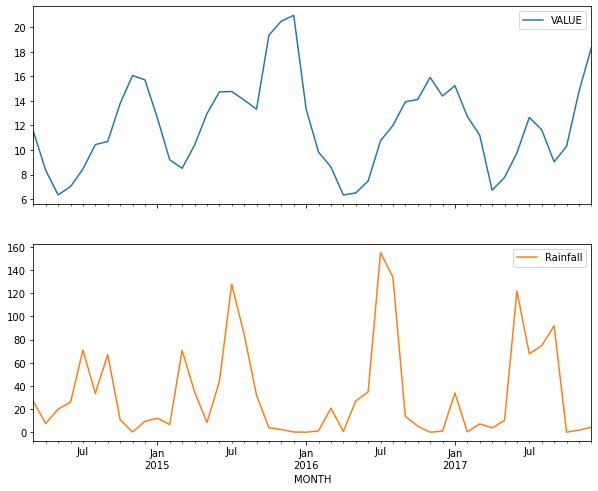

In [141]:
ABC_df_Pesticides.plot(subplots=True)

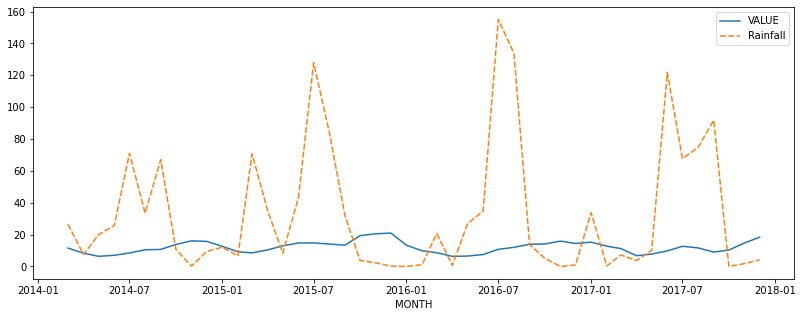

In [142]:
plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
sns.lineplot(data=ABC_df_Pesticides)

In [143]:
#to find the coorelation betwween Rainfall and Value

In [144]:
col1 = ABC_df_Pesticides["Rainfall"]
col2 = ABC_df_Pesticides["VALUE"]

In [145]:
correlation = col1.corr(col2)
correlation

-0.1759831087352205

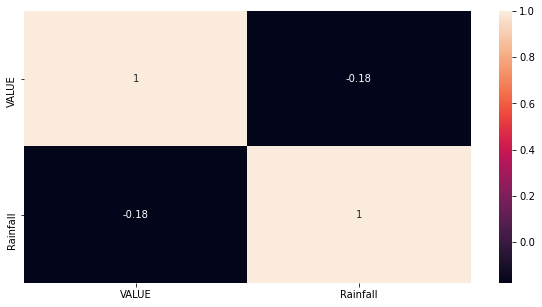

In [146]:
plt.figure(figsize = (10,5))
sns.heatmap(ABC_df_Pesticides.corr(),annot = True)